<a href="https://colab.research.google.com/github/jessecanada/MAPS/blob/master/MAPS_2_1_Cell_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MAPS Module 2.1 - Cell Detection with Azure**
This notebook will guide you through using your own Azure object detection model to perform cell detection and crop out individual cells from your images.
<br>
<br> 
Before you begin, follow this guide to create and train your own Azure model:  https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/get-started-build-detector
<br> 
<br>
Note: model training is code-free!
---

## Step 1: Install Azure Custom Vision SDK and other libraries

In [ ]:
# install Azure SDK
!pip -q install azure-cognitiveservices-vision-customvision

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [ ]:
# import Azure related libraries
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region

!!! Don't forget to also upload MAPS_util.py to this Colab session !!!

## Step 2: Setup your Azure trainer and predictor. Follow [this guide](https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/quickstarts/object-detection?tabs=visual-studio&pivots=programming-language-python) to locate the attributes

In [ ]:
# Populate the following fields with attributes from your Custom Vision object detection project.

ENDPOINT = "your-endpoint" # for ex: https://westus2.api.cognitive.microsoft.com/
training_key = "your-training-key"
prediction_key = "your-prediction-key"
prediction_resource_id = "your-prediction-resource-id" # click on the resource's Overview tab, listed as Subscription ID

In [ ]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

In [ ]:
# list your projects
for project_name in trainer.get_projects():
  print(project_name)

{'additional_properties': {}, 'id': '1eae5342-91d5-4f2c-9848-9652c1e13b36', 'name': 'PTEN_classification', 'description': 'classify PTEN variant localization', 'settings': <azure.cognitiveservices.vision.customvision.training.models._models_py3.ProjectSettings object at 0x7f7974dc1a20>, 'created': datetime.datetime(2020, 1, 9, 22, 59, 28, 490000, tzinfo=<isodate.tzinfo.Utc object at 0x7f7974e78dd8>), 'last_modified': datetime.datetime(2020, 1, 9, 22, 59, 28, 490000, tzinfo=<isodate.tzinfo.Utc object at 0x7f7974e78dd8>), 'thumbnail_uri': None, 'dr_mode_enabled': False, 'status': 'Succeeded'}
{'additional_properties': {}, 'id': '852eead8-f80d-4645-9c3d-5ba1fa221df2', 'name': 'PTEN_obj_detect', 'description': 'detect cells expressing PTEN', 'settings': <azure.cognitiveservices.vision.customvision.training.models._models_py3.ProjectSettings object at 0x7f7974dc1dd8>, 'created': datetime.datetime(2019, 10, 4, 15, 53, 58, 703000, tzinfo=<isodate.tzinfo.Utc object at 0x7f7974e78dd8>), 'last_m

In [ ]:
# copy the 'id' value of your object detection project and paste it below
project = trainer.get_project(project_id="852eead8-f80d-4645-9c3d-5ba1fa221df2")
# if project is loaded successfully you should see it returned
project.id

'852eead8-f80d-4645-9c3d-5ba1fa221df2'

In [ ]:
# list published iterations of your obj detection model
for it in trainer.get_iterations(project.id):
  print(it.name)

Iteration 6
Iteration 4
Iteration 3


In [ ]:
# specify the iteration you want to use (without spaces)
publish_iteration_name = "Iteration4"

## Step 3: Get the input images ready
We recommand uploading them as a zip file to Google Drive and follow the steps below to link the file to this VM. Alternatively, upload directly to this VM.

In [ ]:
# It is recommended that you upload your source images as a zip file onto Google Drive.
# Then, the following cells will import  images for use in this session.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip
!unzip path-to-your-input-images.zip -d /content/

## Step 4: Start Azure object detection

### (optional) convert TIF to JPEG

In [ ]:
# (optional) convert TIF to JPEG
from PIL import Image
import glob

wrk_dir = '/content/cells/' # replace with your image directory

for name in glob.glob(wrk_dir + '*.TIF'):
    im = Image.open(name)
    name = str(name).rstrip(".TIF")
    im.save(name + '.jpg', 'JPEG')

### Make predictions

Send images to Azure for predictions, and return a dataframe of predicted bounding boxes

In [ ]:
img_dir = '/content/cells/' # replace with your image directory

df_predict = pd.DataFrame(columns=['probability (%)', 'x', 'y', 'w', 'h', 'image_ID'])

for file in os.scandir(img_dir):
  x = []
  y = []
  w = []
  h = []
  prob = []
  if file.name.endswith('.jpg'):
    img_ID = file.name[:-4]
    # Open an image and get back the prediction results
    with open(img_dir+file.name, mode="rb") as img: #'r'-read, 'b'-binary (for images)
      results = predictor.detect_image(project.id, publish_iteration_name, img)
    # Display the results    
    for prediction in results.predictions:
      if prediction.probability > 0.6: # probability threshold = 60%
        prob.append(prediction.probability*100)
        x.append(prediction.bounding_box.left)
        y.append(prediction.bounding_box.top)
        w.append(prediction.bounding_box.width)
        h.append(prediction.bounding_box.height)
        
    df_temp = pd.DataFrame({'probability (%)': prob, \
                   'x': x, 'y': y, 'w': w, 'h': h})
    df_temp['image_ID'] = img_ID
    print(df_temp.head())

    df_predict = df_predict.append(df_temp, ignore_index=True)


   probability (%)         x  ...         h                    image_ID
0        84.408206  0.160518  ...  0.054666  merged_191120110001_C02f40
1        83.202860  0.144384  ...  0.063359  merged_191120110001_C02f40
2        78.674860  0.860872  ...  0.081033  merged_191120110001_C02f40
3        75.926745  0.412356  ...  0.081691  merged_191120110001_C02f40
4        71.810570  0.466818  ...  0.075619  merged_191120110001_C02f40

[5 rows x 6 columns]
   probability (%)         x  ...         h                    image_ID
0         81.25516  0.412041  ...  0.019065  merged_191120110001_C02f73
1         66.65441  0.013656  ...  0.044180  merged_191120110001_C02f73

[2 rows x 6 columns]
   probability (%)         x  ...         h                    image_ID
0        87.070620  0.232231  ...  0.096209  merged_191120110001_C02f49
1        80.799586  0.838701  ...  0.079646  merged_191120110001_C02f49
2        73.327625  0.272319  ...  0.023006  merged_191120110001_C02f49
3        61.710227  

In [ ]:
df_predict.head()

,probability (%),x,y,w,h,image_ID
0,84.408206,0.160518,0.467983,0.065699,0.054666,merged_191120110001_C02f40
1,83.202860,0.144384,0.575391,0.046243,0.063359,merged_191120110001_C02f40
2,78.674860,0.860872,0.046315,0.099733,0.081033,merged_191120110001_C02f40
3,75.926745,0.412356,0.175945,0.119778,0.081691,merged_191120110001_C02f40
4,71.810570,0.466818,0.308091,0.083961,0.075619,merged_191120110001_C02f40


In [ ]:
# save bboxes df 
df_predict.to_csv('predicted_bboxes.csv', index=False)

# download the csv, or copy it to Google Drive
!cp predicted_bboxes.csv /content/drive/your-destination-folder

### Inspect prediction results

In [ ]:
from MAPS_util import plot_rectangles

merged_191120110001_C02f66


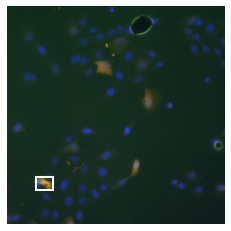

merged_191120110001_C02f81


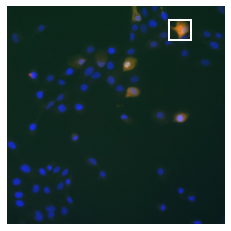

merged_191120110001_C02f72


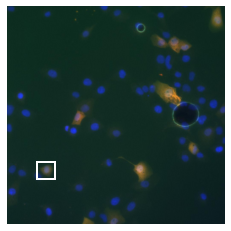

In [ ]:
plot_interval = 4 # Will plot every 4th image with the bounding boxes
wrk_dir = '/content/cells' # Replace with your image directory

for i, file in enumerate(os.scandir(wrk_dir)):
  if i % plot_interval == 0:
    if file.name.endswith('.jpg'):
      # read image
      image = cv2.imread(file.path, -1)
      image_ID = file.name[:-4]
      print(image_ID)
      img_height, img_width, img_channel = image.shape
      
      # Retrieve all predicted bounding boxes for the current image
      bbox_df = df_predict.loc[df_predict['image_ID'] == image_ID, ['x', 'y', 'w', 'h']].reset_index(drop=True)
    
      # Plot current image with predictedbboxes
      fig, ax = plt.subplots(1,1, figsize=(4, 4))
      ax.imshow(image[:,:,::-1]) # OpenCV loads img in BGR. Reverse channels for matplotlib
      rectangles = plot_rectangles(img_height, img_width, bbox_df) # Create rectangle patches
      ax.add_patch(rectangles) # Add patches to the Axes
      ax.set_axis_off()
      plt.show(); plt.close()

### Isolate ROIs, save them as individual images

In [ ]:
# function to show cropped single cells
def imshow_ROIs(ROI_list):
  n = len(ROI_list)
  fig, axes = plt.subplots(1,n)
  for i, ax in enumerate(axes.ravel()):
    ax.imshow(ROI_list[i][:,:,::-1])
    ax.set_axis_off()
  plt.show(); plt.close()

In [ ]:
# create a new folder to save cropped cells
!mkdir cropped_ROIs

In [ ]:
df_predict = pd.read_csv("predicted_bboxes.csv", index_col=False)

current image: merged_191120110001_C02f40


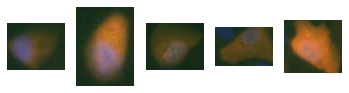

saved 5 ROIs 

current image: merged_191120110001_C02f73
saved 2 ROIs 

current image: merged_191120110001_C02f49
saved 4 ROIs 

current image: merged_191120110001_C02f52
saved 5 ROIs 

current image: merged_191120110001_C02f50


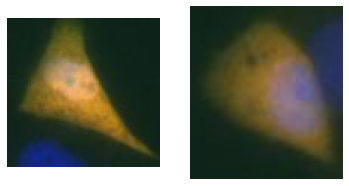

saved 2 ROIs 

current image: merged_191120110001_C02f51
saved 2 ROIs 

current image: merged_191120110001_C02f55
saved 4 ROIs 

current image: merged_191120110001_C02f66
saved 4 ROIs 

current image: merged_191120110001_C02f77


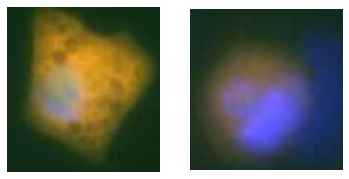

saved 2 ROIs 

current image: merged_191120110001_C02f80
saved 2 ROIs 

current image: merged_191120110001_C02f83
saved 4 ROIs 

current image: merged_191120110001_C02f68
saved 6 ROIs 

current image: merged_191120110001_C02f47


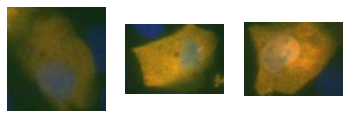

saved 3 ROIs 

current image: merged_191120110001_C02f81
saved 5 ROIs 

current image: merged_191120110001_C02f44
saved 2 ROIs 

current image: merged_191120110001_C02f43
saved 4 ROIs 

current image: merged_191120110001_C02f41


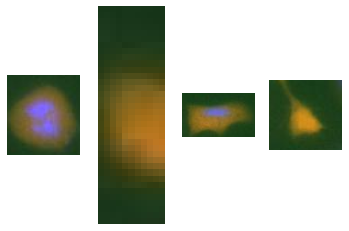

saved 4 ROIs 

current image: merged_191120110001_C02f42
saved 6 ROIs 

current image: merged_191120110001_C02f45
saved 2 ROIs 

current image: merged_191120110001_C02f72
saved 4 ROIs 

current image: merged_191120110001_C02f48


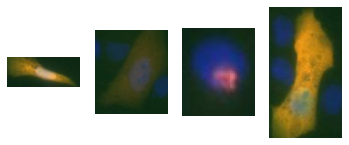

saved 4 ROIs 

current image: merged_191120110001_C02f54
saved 2 ROIs 

current image: merged_191120110001_C02f56
saved 3 ROIs 

current image: merged_191120110001_C02f75
saved 2 ROIs 

current image: merged_191120110001_C02f53


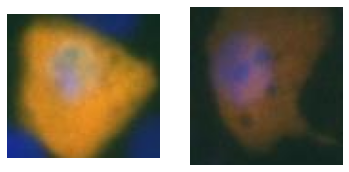

saved 2 ROIs 



In [ ]:
# specify source + destination folders
wrk_dir = '/content/cells/'
dst_dir = '/content/cropped_ROIs/'

plot_interval = 4 # Will plot every 4th image with the bounding boxes

for i, image_ID in enumerate(df_predict['image_ID'].unique()):
  print(f'current image: {image_ID}')
  bbox_df = df_predict.loc[df_predict['image_ID'] == image_ID, ['x','y','w','h']].reset_index(drop=True)
  image = cv2.imread(f'{wrk_dir}{image_ID}.jpg', -1)
  img_height, img_width, img_channel = image.shape
  
  # save each ROI as a separate image file
  detected_ROIs = []
  for j in range(len(bbox_df)):
    x = int(img_width * bbox_df.x[j])
    y = int(img_height * bbox_df.y[j])  
    w = int(img_width * bbox_df.w[j])
    h = int(img_height * bbox_df.h[j])

    ROI = image[y:y+h, x:x+w]
    cv2.imwrite(f'{dst_dir}{image_ID}_{j}.jpg', ROI)
    detected_ROIs.append(ROI)
  
  # plot ROIs to inspect at set plot_interval
  if i % plot_interval == 0:
    imshow_ROIs(detected_ROIs)
  print(f'saved {len(detected_ROIs)} ROIs', '\n')

In [ ]:
# how many ROIs?
!ls cropped_ROIs/ | wc -l

85


In [ ]:
# zip the cropped ROIs
!zip -r cropped_ROIs.zip cropped_ROIs/

  adding: cropped_ROIs/ (stored 0%)
  adding: cropped_ROIs/merged_191120110001_C02f52_3.jpg (deflated 5%)
  adding: cropped_ROIs/merged_191120110001_C02f49_1.jpg (deflated 6%)
  adding: cropped_ROIs/merged_191120110001_C02f52_2.jpg (deflated 13%)
  adding: cropped_ROIs/merged_191120110001_C02f55_1.jpg (deflated 6%)
  adding: cropped_ROIs/merged_191120110001_C02f56_1.jpg (deflated 9%)
  adding: cropped_ROIs/merged_191120110001_C02f83_0.jpg (deflated 5%)
  adding: cropped_ROIs/merged_191120110001_C02f72_3.jpg (deflated 8%)
  adding: cropped_ROIs/merged_191120110001_C02f66_2.jpg (deflated 11%)
  adding: cropped_ROIs/merged_191120110001_C02f42_1.jpg (deflated 14%)
  adding: cropped_ROIs/merged_191120110001_C02f68_2.jpg (deflated 7%)
  adding: cropped_ROIs/merged_191120110001_C02f81_4.jpg (deflated 5%)
  adding: cropped_ROIs/merged_191120110001_C02f52_1.jpg (deflated 8%)
  adding: cropped_ROIs/merged_191120110001_C02f48_2.jpg (deflated 14%)
  adding: cropped_ROIs/merged_191120110001_C02f68_

In [ ]:
# download the zip file or copy it to Google Drive
!cp cropped_ROIs.zip Google-Drive-destination